# Retrospective look at car efficiency

### by Karma Tsering
My goal is to predict efficiency of a car of 70s and 80s'.

### Motivation behind the analysis
> Improving fuel efficiency has financial as well as social and environmental benefits. Extraction of raw material to build these vehicles causes harm to local ecosystems[1], aquatic contamination[2], and earthquakes[3] so it would make sense to reduce the requirement of these raw materials to reduce their impact. Transportation is responsible for contributing 30% of toxic emissions polluting the envroment[4]. Fuel Efficiency can be improved with Advanced Design, Materials, and Technologies.

>Building models to predict the efficiency of the car can help consumers make better decisions and/or manufacturers by focusing their resources to minimize the negative impact because cars are here to stay.

### Data Source

> This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset was used in the 1983 American Statistical Association Exposition.
This dataset was collected of car in the 1970s and the 1980s, contain information such as the name, MPG, number of cylinders, horsepower, engine size, origin of the car and weight. 
The Auto MPG sample data set is a collection of 398 automobile records with 9 variables, 3 of them are categorical and 5 are continues. This simple data can be very useful for practicing some useful analysis techniques and visualizations that you can then apply to your own data sets.

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import neighbors
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [76]:
#load data set and randomize it and save it new file
auto_mpg_df = pd.read_table('auto-mpg.data-original.csv', delimiter=',').dropna().sample(frac=1) #.reset_index(drop=True)
#auto_mpg_df.to_csv('auto-mpg.data-original2.csv')
auto_mpg_df.head()

,MPG,Cylinders,Displacement,horsepower,Weight,Acceleration,Model_Year,Origin,Car Name
61,35.0,4,72.0,69.0,1613,18.0,71,3,datsun 1200
187,25.0,4,121.0,115.0,2671,13.5,75,2,saab 99le
285,31.5,4,89.0,71.0,1990,14.9,78,2,volkswagen scirocco
152,32.0,4,83.0,61.0,2003,19.0,74,3,datsun 710
298,19.2,8,267.0,125.0,3605,15.0,79,1,chevrolet malibu classic (sw)


In [94]:
#load the randomized data in pandas dataframe
auto_mpg_df = pd.read_table('auto-mpg.data-original2.csv', delimiter=',')
auto_mpg_df = auto_mpg_df.drop('Unnamed: 0', 1)
auto_mpg_df.head()

,MPG,Cylinders,Displacement,horsepower,Weight,Acceleration,Model_Year,Origin,Car Name
0,12.0,8,400.0,167.0,4906,12.5,73,1,ford country
1,28.0,4,116.0,90.0,2123,14.0,71,2,opel 1900
2,39.4,4,85.0,70.0,2070,18.6,78,3,datsun b210 gx
3,23.8,4,151.0,85.0,2855,17.6,78,1,oldsmobile starfire sx
4,23.0,4,140.0,78.0,2592,18.5,75,1,pontiac astro


In [5]:
auto_mpg_df.describe()

,MPG,Cylinders,Displacement,horsepower,Weight,Acceleration,Model_Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


#### Graphical exploratory analysis using seaborn pair plot, a very handy tool to do a quick overview. Shows relationship between all the variables. Visualization of the graphs can allow to make decision of required non-linear transformation. The variable Origin’s values are replaced with their text counterpart for visualization purpose only, will not be used for analysis, it is a categorical variable therefore correlation information is irrelevant. 

In [100]:
#Name the Origin of the cars for graphing porpuse, will not be used for analysis
Origin = pd.DataFrame(auto_mpg_df['Origin'].where(auto_mpg_df['Origin'] != 1, 'North America'))
Origin = Origin.where(Origin != 2, 'Europe')
Origin = Origin.where(Origin != 3, 'Asia')
auto_mpg_df2 = auto_mpg_df.drop('Cylinders', 1)
auto_mpg_df2['Origin'] = Origin

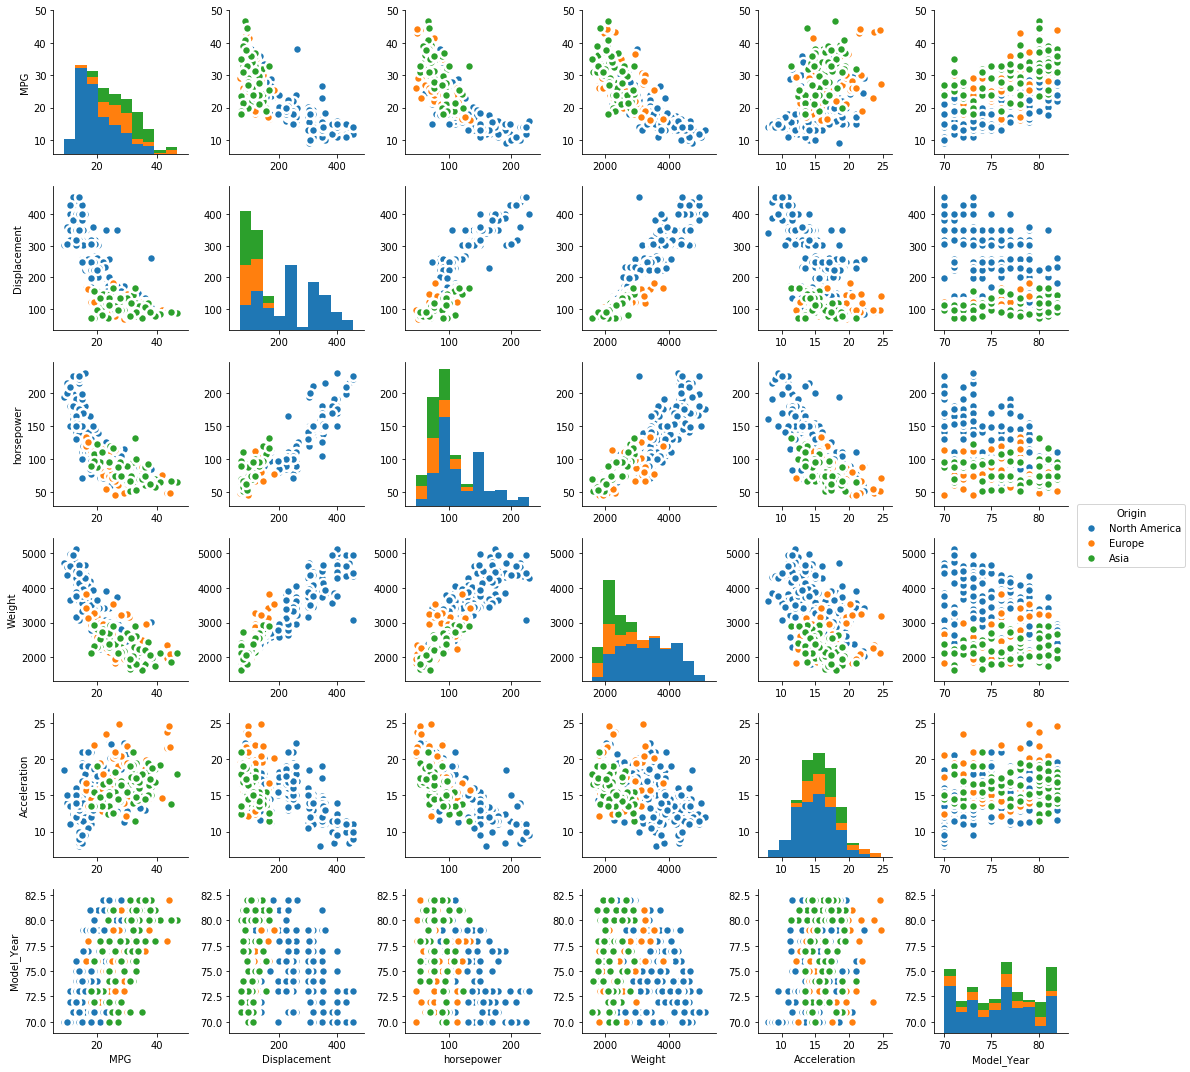

In [89]:
#Exploratory look at relationship between all the variable, except for 'Car Name'
sns.pairplot(auto_mpg_df2, kind='scatter', hue='Origin', plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.savefig('autompg_expolatory.png', bbox_inches='tight')
plt.show()

In [11]:
#Removing outliers and creating new feature
auto_mpg_df = auto_mpg_df.drop([121, 129, 204])

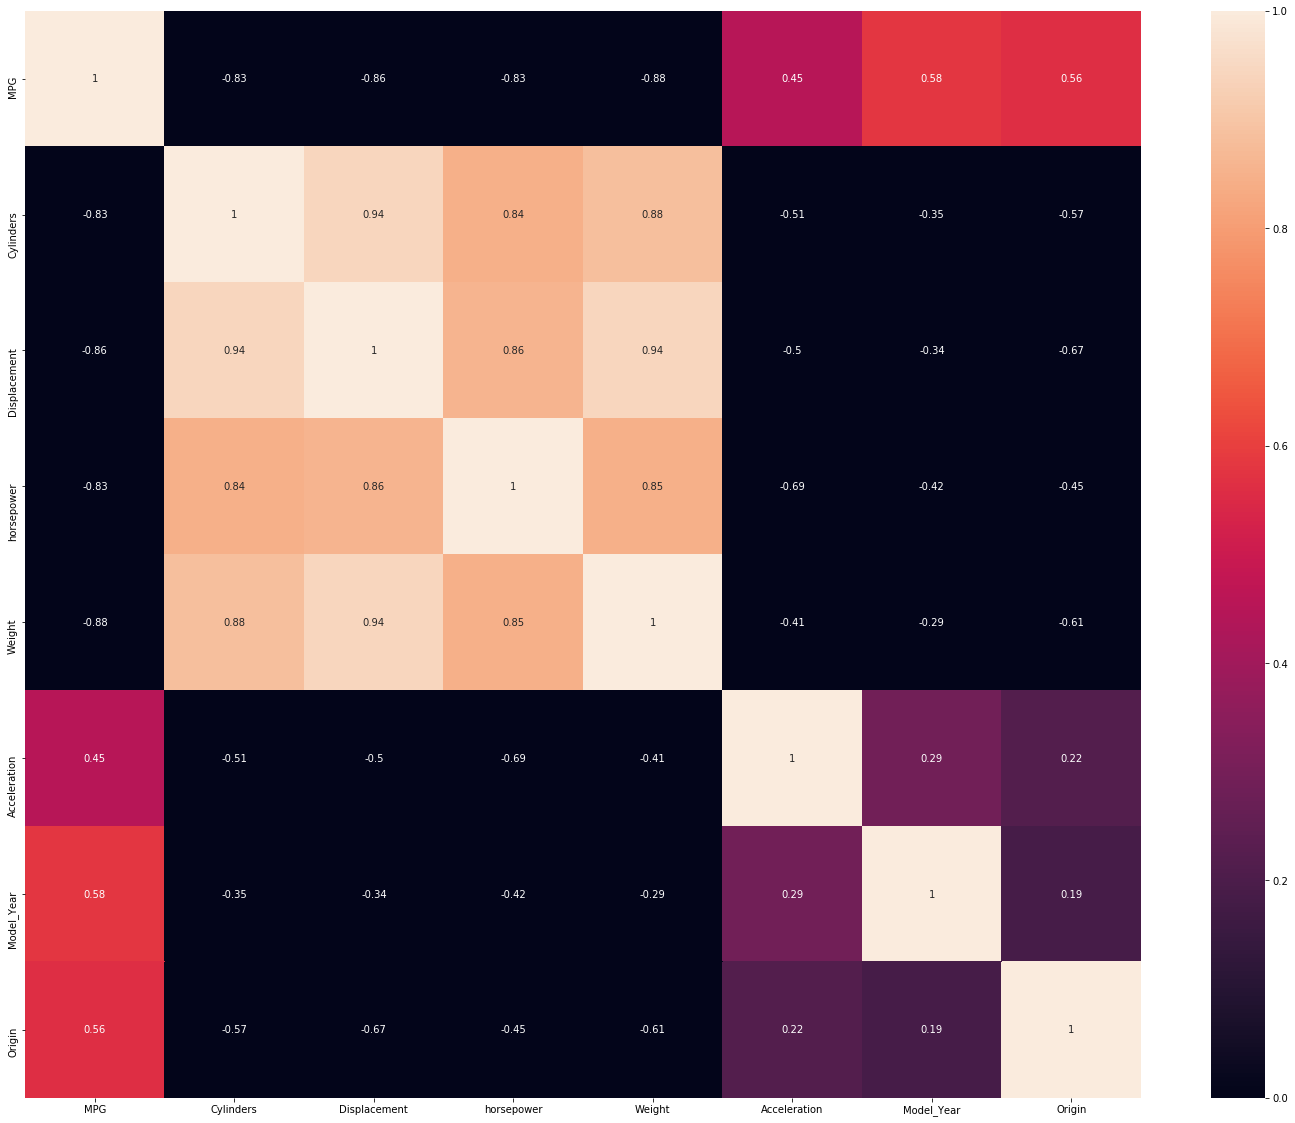

In [13]:
#head map with corrilation value within
plt.subplots(figsize=(25,20)) 
sns.heatmap(auto_mpg_df.corr(), annot=True, vmin=0, vmax=1)
#plt.savefig('corrheatmap.png', bbox_inches='tight')
plt.show()

## Feature engineering

#### Almost all the variables have high correlation with output variable. Some of the input variables have high correlation relations such as between 'horsepower' and 'Displacement'. In place of simply dropping one of them to eliminate multi-collinearity, a new feature 'Engine' is created, which is combination of 'Displacement' and 'Cylinders'. Multi-collinearity contributes to overfitting.

In [30]:
#Create new feature from 'Displacement' and 'Cylinders'
auto_mpg_df['Engin'] = auto_mpg_df['Displacement'] * auto_mpg_df['Cylinders']

In [31]:
#applying a non-linear transformation function to features
auto_mpg_df['Displacement'] = np.log(auto_mpg_df['Displacement'])
auto_mpg_df['Weight'] = np.log(auto_mpg_df['Weight'])
auto_mpg_df['MPG'] = np.log(auto_mpg_df['MPG'])
auto_mpg_df['Engin'] = np.log(auto_mpg_df['Engin'])
auto_mpg_df['horsepower'] = np.log(auto_mpg_df['horsepower'])

In [102]:
#Drop all the cylinder 3 and 5 data because we don't have enough of them to make good prediction for them
cy5 = auto_mpg_df[auto_mpg_df['Cylinders'] == 5]
cy3 = auto_mpg_df[auto_mpg_df['Cylinders'] == 3]

cytodrop = pd.concat([cy3, cy5])
cyindex = cytodrop.index.values
auto_mpg_df2 = auto_mpg_df2.drop(cyindex)

In [84]:
#Drop all the cylinder 3 and 5 data because we don't have enough of them to make good prediction for them
cy5 = auto_mpg_df[auto_mpg_df['Cylinders'] == 5]
cy3 = auto_mpg_df[auto_mpg_df['Cylinders'] == 3]

cytodrop = pd.concat([cy3, cy5])
cyindex = cytodrop.index.values
auto_mpg_df = auto_mpg_df.drop(cyindex)

In [33]:
# Create a set of dummy variables from the sex variable
df_Cylinders = pd.get_dummies(auto_mpg_df['Cylinders'])
df_Origin = pd.get_dummies(auto_mpg_df['Origin'])

# Join the dummy variables to the main dataframe
auto_mpg_df = pd.concat([auto_mpg_df, df_Cylinders, df_Origin], axis=1)
auto_mpg_df = auto_mpg_df.drop(['Cylinders', 'Origin', 'Car Name'], 1)
auto_mpg_df.head()

,MPG,Displacement,horsepower,Weight,Acceleration,Model_Year,Engin,4,6,8,1,2,3
0,2.484907,5.991465,5.117994,8.498214,12.5,73,8.070906,0,0,1,1,0,0
1,3.332205,4.753590,4.499810,7.660585,14.0,71,6.139885,1,0,0,0,1,0
2,3.673766,4.442651,4.248495,7.635304,18.6,78,5.828946,1,0,0,0,0,1
3,3.169686,5.017280,4.442651,7.956827,17.6,78,6.403574,1,0,0,1,0,0
4,3.135494,4.941642,4.356709,7.860185,18.5,75,6.327937,1,0,0,1,0,0


In [34]:
#Create input and outcome variable
X = auto_mpg_df.drop('MPG', 1)
y = auto_mpg_df['MPG']

#Split the input and outcome into, train and test dataset for analysis
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=20)

## Regression Models
#### Oridenary least squared (OLS), Lasso, Ridge and Support Vector Machine regression models build. To see how they work and how they compare to other models.

## OLS regression

# $$y_i =  X\beta + \epsilon$$

In [1]:
#Ordernary least squre regression, the simples regression
regr = linear_model.LinearRegression()
regr.fit(X_train2, y_train2)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test2, y_test2))

#cross validation to check for overfitting, can be done using 
k = cross_val_score(regr, X, y, cv=5)
k.sort()
print('\n mean r2')
print(np.mean(k))
k

NameError: name 'linear_model' is not defined

In [36]:
#check variablity of the crossvalidation result, high variablity mean overfitting
max(k) -min(k)

0.039658398041712006

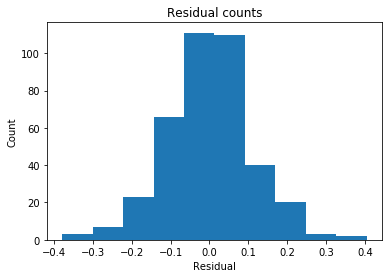

In [37]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = y

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning. Linear regression assumes normal distripution
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

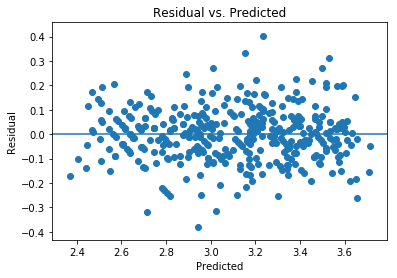

0.781670915901


In [38]:
#Linear regression assumes consistend distribution, inconsisted distribution could cause over confidence in result
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print(max(residual)-min(residual))

# Lasso regression

In [56]:
lass = linear_model.Lasso(alpha=0.001145)
lass.fit(X_train2, y_train2)

print('R² for the model with few features:')
print(lass.score(X_test2, y_test2))
origparams = np.append(lass.coef_, lass.intercept_)
print('\nParameter estimates for the model with few features:')
print(str(origparams) + '\n')

k = cross_val_score(lass, X, y, cv=5)
k.sort()
print('\n mean r2')
print(np.mean(k))
k

R² for the model with few features:
0.892635016793

Parameter estimates for the model with few features:
[ -0.00000000e+00  -2.56169008e-01  -5.18965632e-01  -1.01153746e-02
   2.88852984e-02  -5.39633067e-02   6.16034719e-03  -1.98380339e-02
   0.00000000e+00  -2.66012355e-02   0.00000000e+00   0.00000000e+00
   6.75317333e+00]


 mean r2
0.892959775564


array([ 0.87804962,  0.88380134,  0.88715789,  0.89989337,  0.91589666])

In [57]:
#check variablity, low is good
max(k) -min(k)

0.037847043877602626

In [51]:
#Finding optimal alpha value
alphas = 10**np.linspace(-1,-2,100)*0.5

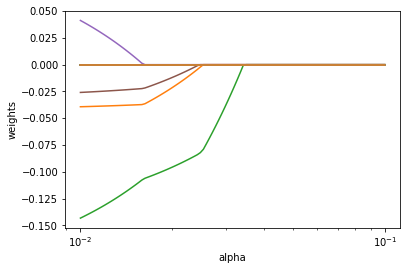

In [52]:
#find the optimal alpha value for the model
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train2), y_train2)
    coefs.append(lasso.coef_)
    
#Graph showing coef. change as alpha change, goal is to minimize coef. but zero alpha means the model is OLS model
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [53]:
#optimal alpha value using mininum cross validation variablitiy
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100000, normalize = True)
lassocv.fit(X_train2, y_train2)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train2, y_train2)
print(lassocv.alpha_)
mean_squared_error(y, lasso.predict(X))

0.000129930705001


0.011606149214135948

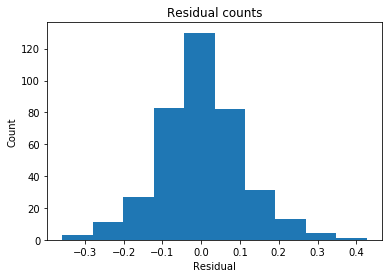

In [58]:
# Extract predicted values.
predicted = lass.predict(X).ravel()
actual = y

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

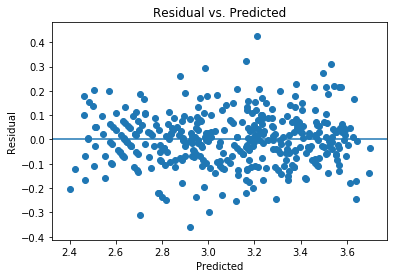

0.784946422554


In [59]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print(max(residual)-min(residual))

# ridge regression

In [65]:
#ridge regression with no set intercept because the whole equation will increase by some constant off true value
ridgeregr = Ridge(alpha=0.006609705742330144, fit_intercept=False, normalize = True)
ridgeregr.fit(X_train2, y_train2)
print(ridgeregr.score(X_test2, y_test2))
print('Cross Validation')
origparams = np.append(ridgeregr.coef_, ridgeregr.intercept_)
print('\nParameter estimates for the model with few features:')
print(str(origparams) + '\n')
k = cross_val_score(ridgeregr, X, y, cv=5)
k.sort()
print(np.mean(k))
k

0.888992421626
Cross Validation

Parameter estimates for the model with few features:
[-2.56011408 -0.29584322 -0.56773255 -0.01063495  0.02936885  2.59116277
  2.10330929  0.97761436  0.23266885  1.07422241  1.11942916  1.11994093
  0.        ]

0.893191298245


array([ 0.87688734,  0.88401718,  0.88801868,  0.90118591,  0.91584739])

In [66]:
max(k) -min(k)

0.038960049715326073

In [67]:
#Finding optimal alpha value
alphas = 10**np.linspace(10,-2,100)*0.5
alphas
coefs = []

for a in alphas:
    ridgeregr.set_params(alpha = a)
    ridgeregr.fit(X_train2, y_train2)
    coefs.append(ridgeregr.coef_)
    

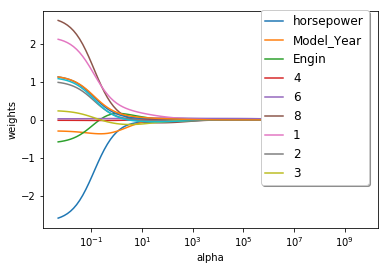

In [68]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(('horsepower', 'Model_Year','Engin',4,6,8,1,2,3),
           shadow=True, loc=(0.65, 0.2), handlelength=1.5, fontsize=12)
plt.show()

In [64]:
#optical alpha value by minimizing varibility of cross-validation result
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train2, y_train2)
ridgecv.alpha_

0.006609705742330144

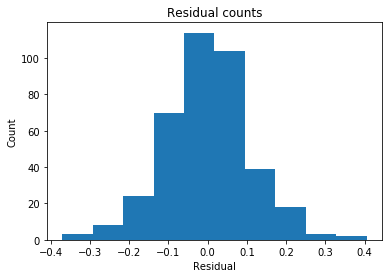

In [69]:
# Extract predicted values.
predicted = ridgeregr.predict(X).ravel()
actual = y

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

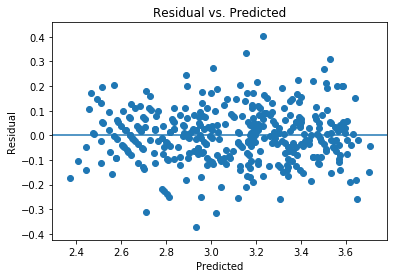

0.775362721742


In [70]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print(max(residual)-min(residual))

# SVM

In [71]:
#Support vector used mainly for classification and dataset with many feature (>10^6)
#Its in the mix to see what it can do and how does it compare
svr = SVR()

svr.fit(X_train2, y_train2)
print(ridgeregr.score(X_test2, y_test2))
print('Cross Validation')
k = cross_val_score(ridgeregr, X, y, cv=5)
k.sort()
k

0.888513387907
Cross Validation


array([ 0.87670815,  0.88377408,  0.88876473,  0.90126723,  0.91582126])

In [72]:
max(k) -min(k)

0.03911311304328946

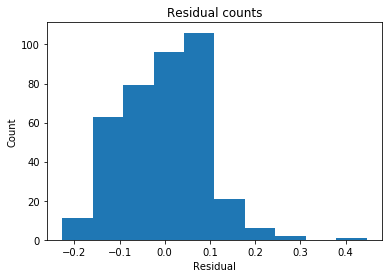

In [73]:
# Extract predicted values.
predicted = svr.predict(X).ravel()
actual = y

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

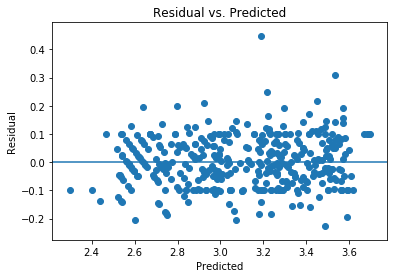

0.673466201917


In [74]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print(max(residual)-min(residual))

### References
1. Williams, H.F.L., D.L. Havens, K.E. Banks, and D.J. Wachal. 2008. Field-based monitoring of sediment runoff from natural gas well sites in Denton County, Texas, USA. Environmental Geology 55:1463–1471.
2. Burton, G.A., K.J. Nadelhoffer, and K. Presley. 2013. Hydraulic fracturing in the state of Michigan: Environment/ecology technical report. University of Michigan. September 3.
3. National Research Council. 2013. Induced seismicity potential in energy technologies. Washington, DC: The National Academies Press. 
4. Kahn Ribeiro, S., S. Kobayashi, M. Beuthe, J. Gasca, D. Greene, D. S. Lee, Y. Muromachi, P. J. Newton, S. Plotkin, D. Sperling, R. Wit, P. J. Zhou (2007). Transport and its infrastructure. In Climate Change 2007: Mitigation. http://www.ipcc.ch/publications_and_data/ar4/wg3/en/ch5.html

# End of model

4    199
8    103
6     83
3      4
5      3
Name: Cylinders, dtype: int64


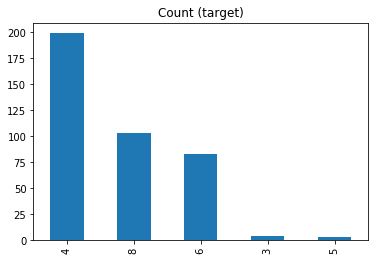

In [78]:
#Graph to illistrate the insuffecent data point for certin input variable
target_count = auto_mpg_df.Cylinders.value_counts()

print(target_count)
#print('Class 1:', target_count[1])
#print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');
plt.savefig('autompg_cylinder_count.png', bbox_inches='tight')
plt.show() 

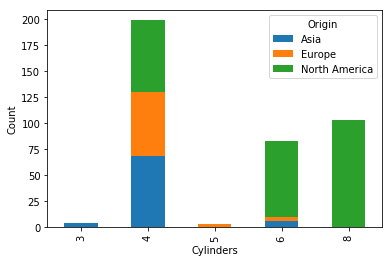

In [101]:
#Graph to illistrate the insuffecent data point for certin input variable
auto_mpg_df2.groupby(['Cylinders', 'Origin'])['MPG'].size().unstack().plot(kind='bar', stacked=True)
plt.ylabel('Count')
plt.savefig('autompg_cylinder_count.png', bbox_inches='tight')
plt.show()

4    199
8    103
6     83
3      4
5      3
Name: Cylinders, dtype: int64


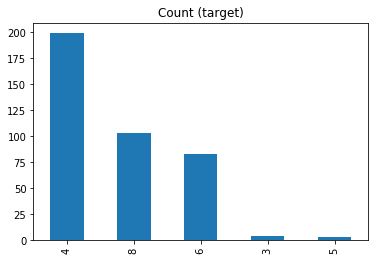

In [81]:
target_count = auto_mpg_df.Cylinders.value_counts()

print(target_count)
#print('Class 1:', target_count[1])
#print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');
plt.show()

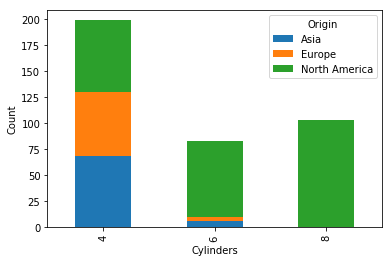

In [104]:
#Graph to illistrate the insuffecent data point for certin input variable#Graph to illistrate fix for the insuffecent data point for certin input variable
auto_mpg_df2.groupby(['Cylinders', 'Origin'])['MPG'].size().unstack().plot(kind='bar', stacked=True)
plt.ylabel('Count')
plt.savefig('autompg_cylinder_count2.png', bbox_inches='tight')
plt.show()

Hi @Kartse, thanks for asking about the capstone presentation system..

From your dashboard, go to Goals and you should see a Calendly link for scheduling time with a capstone review host.  This link is only available once you have completed all previous goals including a mock interview.

Provided all prior goals have been approved, you will see a Calendly to schedule a host and time that works for you, preferably with a few days notice.

After you select a time slot, come back to the Goals page and you will see a capstone submission form where you will enter a project URL, a title and a story/abstract.

URL: I like the URL to point to a directory in a Github repository. In this directory you may include:

1. project-name.ipynb (include URL to data)
2. project-name.pdf (PDF of slide deck)
3. If your data set is small and unique include it

Title: project name.

Story: say something about the problem you are trying to solve and what tools you used to do them with. Get creative or keep it dry. This is a chance to work on your presentation skills, including summarizing your project in a few sentences.

You may reference what part of the curriculum this capstone addresses (supervised learning, unsupervised learning, or final project).

Hitting the submit button will add an entry into the Workshops where folks may find your abstract/story and RSVP to join your talk.

A nice way to close the loop is to send the Workshop notice to your reviewer to signal that all's good to go and they can look over your code and be prepared to host. Typically, the more lead time you give your reviewer and potential audience, the more you will get out of the process.

Let me know if you have questions, happy to help!